# Plot Maps of ROMY Array

## Imports

In [1]:
from obspy import UTCDateTime
from obspy.clients import fdsn
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize
from obspy.geodetics.base import gps2dist_azimuth
from obspy.geodetics import locations2degrees
from obspy.clients.fdsn    import Client, RoutingClient
from obspy.signal.rotate import rotate2zne
from andbro__savefig import __savefig

import os
import obspy.signal.array_analysis as AA
import matplotlib.pyplot  as plt
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

In [102]:
def __get_coordinates(config, unit="degree"):

    from obspy.signal.util import util_geo_km

    coords = {}
    for i, station in enumerate(config['subarray_stations']):

        net, sta = station.split(".")

        inven = config['fdsn_client'][net].get_stations(network=net,
                                                        station=sta,
                                                        channel='BHZ',
                                                        starttime=config['starttime'],
                                                        endtime=config['starttime']+86400,
                                                        level='response'
                                                       )

        # extract coordinates
        l_lon = float(inven.get_coordinates('%s.%s..BHZ'%(net,sta))['longitude'])
        l_lat = float(inven.get_coordinates('%s.%s..BHZ'%(net,sta))['latitude'])
        height = float(inven.get_coordinates('%s.%s..BHZ'%(net,sta))['elevation'])

        # manual correction
        if sta == "FUR":
            l_lon, l_lat, height = 11.27523, 48.16295, 564.0

        if unit == "degree":
            coords[sta] = [l_lon, l_lat, height]

        if unit == "meter":
            # store reference coordinates
            if sta == config['reference_station'].split(".")[1]:
                o_lon, o_lat, o_height = l_lon, l_lat, height

            # compute relative distances to reference station in km
            lon, lat = util_geo_km(o_lon, o_lat, l_lon, l_lat)

            # store distances as meters
            coords[sta] = [l_lon*1000, l_lat*1000, height-o_height]

    return coords

In [122]:
def __get_distances(config):

    import obspy

    n = len(config['coordinates'].keys())

    cc_lon, cc_lat, cc_height = 0, 0, 0
    for k in config['coordinates'].keys():
        cc_lon += float(config['coordinates'][k][0])
        cc_lat += float(config['coordinates'][k][1])
        cc_height += float(config['coordinates'][k][2])

    cc_lon /= n
    cc_lat /= n
    cc_height /= n

    config['centroid'] = [cc_lon, cc_lat, cc_height]

    dists = []
    for k in config['coordinates'].keys():
        lon, lat, height = config['coordinates'][k]
        dist_x, dist_y = obspy.signal.util.util_geo_km(float(cc_lon), float(cc_lat), float(lon), float(lat))
        dists.append([dist_x*1000, dist_y*1000, float(height)-float(cc_height)]) #convert unit from km to m

    return np.array(dists)

In [117]:
def __get_aperture(config, reference_station=None):

    from numpy import argmax, array, sqrt
    import obspy

    dists, idx = [], []
    for ii, (lon1, lat1, height1) in enumerate(config['coordinates']):
        for jj, (lon2, lat2, height2) in enumerate(config['coordinates']):
            dist_x, dist_y = obspy.signal.util.util_geo_km(lon1, lat1, lon2, lat2)
            dists.append(sqrt((dist_x*1000)**2+(dist_y*1000)**2))  #convert unit from km to m
            idx.append((ii, jj))

    aperture = max(abs(array(dists)))
    idx_max = int(argmax(abs(array(dists))))
    _ii, _jj = idx[idx_max]

    connection = (config['coordinates'][_ii][0], config['coordinates'][_ii][1],
                  config['coordinates'][_jj][0], config['coordinates'][_jj][1])

    print(f" -> Aperture of Array: {round(aperture,2)} m")
    return aperture, connection

In [118]:
def __get_fband_of_array(aperture, apparent_velocity):
    fmin = 0.02 * apparent_velocity / aperture
    fmax = 0.25 * apparent_velocity / aperture
    return round(fmin, 2), round(fmax, 2)

## ROMY ARRAY

In [123]:
# generate configuration object
config = {}

# specify client
config['fdsn_client'] = {"GR":Client('BGR'), "BW":Client("LMU")}
# config['fdsn_client'] = {"GR":Client('BGR'), "BW":Client(base_url="http://jane")}

# starttime for data process
config['starttime'] = UTCDateTime().now()

# specify path to figures
config['output_figs'] = data_path+"romy_array/figures/"

# specify code of array
config['array_code'] = "RMY"

# array information
config['array_stations'] = ["GR.FUR", "BW.FFB1", "BW.FFB2", "BW.FFB3",
                            "BW.TON", "BW.BIB", "BW.GELB", "BW.GRMB", "BW.ALFT",
                           ]

# reference stations for computation of aperture
config['reference_station'] = "GR.FUR"

# config3['subarray_mask'] = [0, 1, 2, 3, 4, 5, 6, 7, 8] ## all
# config3['subarray_mask'] = [0, 4, 5, 6, 7, 8] ## outer
config['subarray_mask'] = [0, 1, 2, 3] ## inner

# adjust for sub array
config['subarray_stations'] = [config['array_stations'][i] for i in config['subarray_mask']]

# request inventories
config['coordinates'] = __get_coordinates(config, unit="degree")

# get distances
config['distances'] = __get_distances(config)


In [176]:
config['distances']

array([[  12.12557495,  -91.56826777,   -4.75      ],
       [  -0.14878013,  -96.68319226,    3.25      ],
       [-102.88000938,   64.88170521,    8.25      ],
       [  90.90291446,  123.36975481,   -6.75      ]])

In [135]:
config['coordinates']

{'FUR': [11.27523, 48.16295, 564.0],
 'FFB1': [11.275065, 48.162904, 572.0],
 'FFB2': [11.273684, 48.164357, 577.0],
 'FFB3': [11.276289, 48.164883, 562.0]}

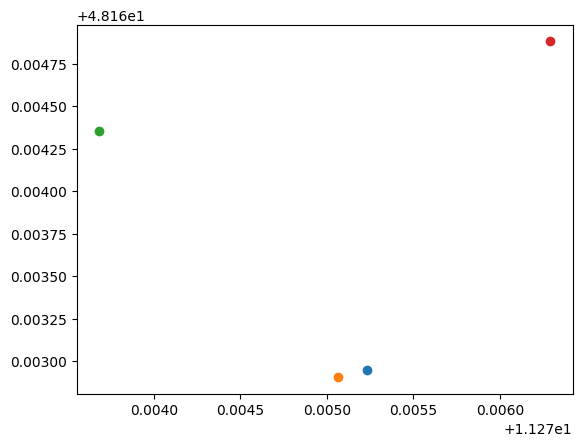

In [175]:
for k in config['coordinates'].keys():
    plt.scatter(float(config['coordinates'][k][0]), float(config['coordinates'][k][1]))
plt.show();

### Get Frequency Band

In [126]:
apparent_velocity = 3500

fmin, fmax = __get_fband_of_array(aperture=238, apparent_velocity=apparent_velocity)
print("ADRi: ", fmin, fmax)

# fmin, fmax = __get_fband_of_array(aperture=501, apparent_velocity=apparent_velocity)
# print("ADRm: ", fmin, fmax)

fmin, fmax = __get_fband_of_array(aperture=4153, apparent_velocity=apparent_velocity)
print("ADRa: ", fmin, fmax)

ADRi:  0.29 3.68
ADRa:  0.02 0.21


## Map

In [127]:
def __plot_array_map(config):

    aper, connect = __get_aperture(config, reference_station=config['reference_station'])

    fig, ax = plt.subplots(1, 1, figsize=(7, 7))

    font = 14

    for n, c in enumerate(config['coordinates']):

        sta = c[0]

        c = [c[1], c[2], c[3]]

        ax.scatter(c[0], c[1], c='r', marker="^", s=80, zorder=2, edgecolors="k")


        ## add labels
        label_adjustments = {"PY.PFOIX":[0, -4e-4], "PY.BPH01": [0, 2e-4],"PY.BPH02": [0, 2e-4],"PY.BPH03": [1e-4, -4e-4],
                               "PY.BPH04": [-12e-4, 2e-4],"PY.BPH05": [0, 2e-4],"PY.BPH06": [0, 2e-4],
                               "PY.BPH07": [3e-4, 2e-4],"PY.BPH08": [-14e-4, 2e-4],"PY.BPH09": [0, 2e-4],
                               "PY.BPH10": [0, 2e-4],"PY.BPH11": [0, 2e-4],
                               "PY.BPH12": [0, -4e-4],"PY.BPH13": [0,  2e-4],
                            }

        try:
            # x, y = label_adjustments[sta]
            ax.text(c[0], c[1], sta, zorder=2)
        except:
            print(f"{config['array_stations'][n]} has no label..")

    ## plot centroid
#     ax.scatter(config['centroid'][0], config['centroid'][1], s=100, marker="+", c='k',zorder=2)

    ## plot aperture line
    # ax.plot([connect[0], connect[2]], [connect[1], connect[3]], ls=":", zorder=0, color='k')


    ax.set_title(f"{config['array_code']} array stations | aperture: {int(round(aper,0))} m")

    ax.set_xlabel("Longitude (°)", fontsize=font)
    ax.set_ylabel("Latitude (°)", fontsize=font)

    ax.grid(alpha=0.8, zorder=0, ls=":")


    lat_min, lat_max = config3['coordinates'][:, 2].min(), config3['coordinates'][:, 2].max()
    lon_min, lon_max = config3['coordinates'][:, 1].min(), config3['coordinates'][:, 1].max()
    ax.set_xlim(lon_min-0.001, lon_max+0.0015)
    ax.set_ylim(lat_min-0.001, lat_max+0.0015)

    ax.ticklabel_format(useOffset=False, style='plain')

    plt.show();
    return fig

In [173]:
# fig = __plot_array_map(config);

## Array Response

In [165]:
def __compute_array_response(array_stations, coordinates, reference_station, axis_type="wave_numer", plot=False):

    from obspy.signal.array_analysis import array_transff_wavenumber, array_transff_freqslowness
    from numpy import linspace, shape, arange, pi

    def __calculateDistanceOfStations(array_stations, longitudes, latitudes):

        from obspy.geodetics import locations2degrees
        from numpy import array, nanmax

        array_stations, longitudes, latitudes = array(array_stations), array(longitudes), array(latitudes)

        N = len(array_stations)

        dist_in_deg = np.zeros((N, N))

        for i, station1 in enumerate(array_stations):
            for j, station2 in enumerate(array_stations):
                dist_in_deg[i][j] = locations2degrees(lat1  = latitudes[i], 
                                                      long1 = longitudes[i], 
                                                      lat2  = latitudes[j], 
                                                      long2 = longitudes[j],
                                                      )

        return dist_in_deg, nanmax(dist_in_deg)*111.0

    def __get_aperture(longitudes, latitudes, reference_longitude, reference_latitude):

        from numpy import argmax, array, sqrt
        from obspy.signal.util import util_geo_km

        distances = []
        for lon, lat in zip(longitudes, latitudes):
            dist_x, dist_y = util_geo_km(reference_longitude, reference_latitude, lon, lat)
            distances.append(sqrt((dist_x*1000)**2+(dist_y*1000)**2))  # convert unit from km to m

        aperture = max(abs(array(distances)))

        return aperture

    def __plot_array_response(kx, ky, res_func, aperture):

        from numpy import arange
        from obspy.imaging.cm import obspy_sequential
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        import matplotlib.pyplot as plt

        fig, ax = plt.subplots(1,1, figsize=(7,7))

        font = 14

        colx = ax.pcolor(kx, ky, res_func.T, cmap=obspy_sequential)

        ax.set_title(f"array response | aperture: {int(round(dist_max*1000, 0))} m")

        ax.set_xlabel('wave number (km$^{-1}$)', fontsize=font)
        ax.set_ylabel('wave number (km$^{-1}$)', fontsize=font)

        ax.grid(alpha=0.1, zorder=0, ls="-", color="white")

        ax.ticklabel_format(useOffset=False, style='plain')

        # add colorbar
        cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(colx, cax=cax)

        plt.show();

    # extract coordinates
    longitudes_deg = [config['coordinates'][k][0] for k in config['coordinates'].keys()]
    latitudes_deg = [config['coordinates'][k][1] for k in config['coordinates'].keys()]
    elevations_km = [config['coordinates'][k][2] for k in config['coordinates'].keys()]

    # ____________________________________________________

    dist, dist_max = __calculateDistanceOfStations(array_stations, longitudes_deg, latitudes_deg)

    ref_idx = [n for n, sta in enumerate(array_stations) if sta == reference_station]

    aperture_m = __get_aperture(longitudes_deg, latitudes_deg, longitudes_deg[ref_idx[0]], latitudes_deg[ref_idx[0]])

    print(f" -> Aperture of Array: {round(aperture_m, 2)} m")

    # format coordinates
    coordinates = np.column_stack([longitudes_deg, latitudes_deg, elevations_km])

    if axis_type == "wave_numer":

        ## define minimal lambda
        lambda_min = 2*aperture_m/1000 ## in km

        ## define wavenumber limits
        k_max = 4*pi/lambda_min
        k_step = k_max / 100.

        print(" -> k_max = ", round(k_max, 2), "1/m", "\n -> lambda_min = ", round(lambda_min, 2), "m" )

        ## compute transfer function as a function of wavenumbe
        transff = array_transff_wavenumber(coordinates, k_max, k_step, coordsys='lonlat')

        ## define wavenumber axes
        x_array = arange(-k_max, k_max + k_step * 1.1, k_step) - k_step / 2.
        y_array = arange(-k_max, k_max + k_step * 1.1, k_step) - k_step / 2.

    elif axis_type == "freq_slowness":

        fmin, fmax, fstep = 0, 10, 0.1
        slim, sstep = 1/(fmax*lambda_min), 0.1

        transff = array_transff_freqslowness(coordinates, slim, sstep, fmin, fmax, fstep, coordsys='lonlat')

#         x_array = arange(-fmax, fmax + fstep * 1.1, fstep) - fstep / 2.
        x_array = arange(-slim, slim + sstep * 1.1, sstep) - sstep / 2.
        y_array = arange(-slim, slim + sstep * 1.1, sstep) - sstep / 2.

    if plot:
        __plot_array_response(x_array, y_array, transff, aperture_m)

    return x_array, y_array, transff

In [167]:
x, y, res_func = __compute_array_response(config['subarray_stations'],
                                          config['coordinates'],
                                          reference_station=config['reference_station'],
                                          axis_type="wave_numer",
                                          plot=False
                                          )

 -> Aperture of Array: 228.92 m
 -> k_max =  27.45 1/m 
 -> lambda_min =  0.46 m


In [177]:
def __plot_array_response(kx, ky, res_func):

    from numpy import arange
    from obspy.imaging.cm import obspy_sequential
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    font = 14
    
    colx = ax.pcolor(kx, ky, res_func.T, cmap=obspy_sequential)

    ax.set_xlabel('wave number (km$^{-1}$)', fontsize=font)
    ax.set_ylabel('wave number (km$^{-1}$)', fontsize=font)

    ax.grid(alpha=0.1, zorder=0, ls="-", color="white")

    ax.ticklabel_format(useOffset=False, style='plain')

    # add colorbar
    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(colx, cax=cax)

    plt.show();
    return fig

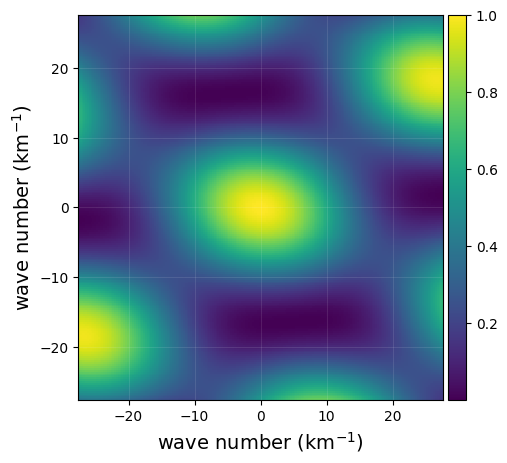

In [178]:
fig = __plot_array_response(x, y, res_func);